In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Data/English/train.csv")

In [3]:
Y_train = df["label"]

# Drop 'label' column
X_train = df.drop(labels = ["label"],axis = 1) 

# free some space
del df

Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

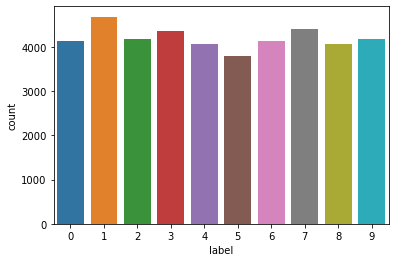

In [4]:
import seaborn as sns
graph = sns.countplot(Y_train)

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
X_train /=  255.0

In [7]:
X_train = X_train.values.reshape(-1,28,28,1).astype('float32')

In [8]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.15, random_state=42)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Dense -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [11]:
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# data augmentation

datagen = ImageDataGenerator(
  
        featurewise_center=False,                      # set input mean to 0 over the dataset
        samplewise_center=False,                       # set each sample mean to 0
        featurewise_std_normalization=False,           # divide inputs by std of the dataset
        samplewise_std_normalization=False,            # divide each input by its std
        zca_whitening=False,                           # apply ZCA whitening
        rotation_range=10,                             # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                              # Randomly zoom image 
        width_shift_range=0.1,                         # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                        # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                         # randomly flip images
        vertical_flip=False)                           # randomly flip images


datagen.fit(X_train)

In [15]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size= 86), epochs = 30, validation_data = (X_val,Y_val),
            verbose = 2, steps_per_epoch=X_train.shape[0] // 86, callbacks=[learning_rate_reduction])

Epoch 1/30
415/415 - 107s - loss: 0.4548 - accuracy: 0.8509 - val_loss: 0.0839 - val_accuracy: 0.9735
Epoch 2/30
415/415 - 108s - loss: 0.1351 - accuracy: 0.9589 - val_loss: 0.0447 - val_accuracy: 0.9868
Epoch 3/30
415/415 - 108s - loss: 0.1020 - accuracy: 0.9698 - val_loss: 0.0359 - val_accuracy: 0.9895
Epoch 4/30
415/415 - 123s - loss: 0.0836 - accuracy: 0.9762 - val_loss: 0.0270 - val_accuracy: 0.9911
Epoch 5/30
415/415 - 116s - loss: 0.0747 - accuracy: 0.9775 - val_loss: 0.0336 - val_accuracy: 0.9900
Epoch 6/30
415/415 - 122s - loss: 0.0698 - accuracy: 0.9803 - val_loss: 0.0309 - val_accuracy: 0.9902
Epoch 7/30
415/415 - 124s - loss: 0.0664 - accuracy: 0.9808 - val_loss: 0.0276 - val_accuracy: 0.9914
Epoch 8/30
415/415 - 132s - loss: 0.0626 - accuracy: 0.9816 - val_loss: 0.0259 - val_accuracy: 0.9914
Epoch 9/30
415/415 - 116s - loss: 0.0610 - accuracy: 0.9825 - val_loss: 0.0323 - val_accuracy: 0.9906
Epoch 10/30
415/415 - 110s - loss: 0.0611 - accuracy: 0.9825 - val_loss: 0.0281 - 

In [16]:
scores = model.evaluate(X_val, Y_val, verbose=0)                                                     

print('Test loss: %.2f%%' % scores[0])
print('Test accuracy: %.4f%%' % scores[1])
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Test loss: 0.02%
Test accuracy: 0.9941%
Large CNN Error: 0.59%


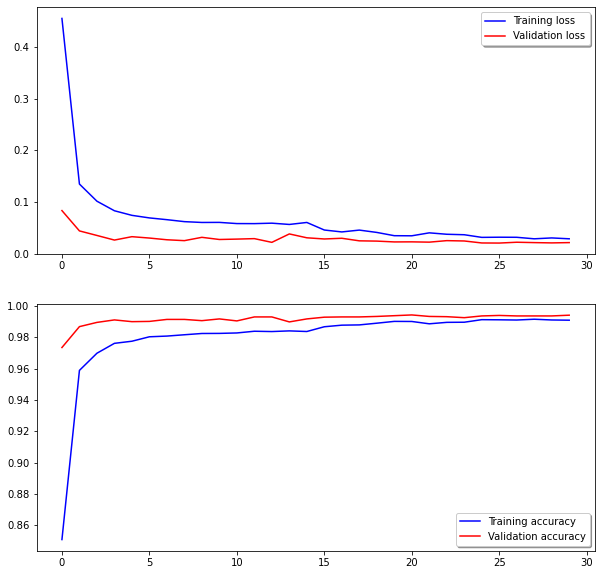

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the loss and accuracy curves for training and validation 

fig, ax = plt.subplots(2,1,figsize=(10, 10))

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
model.save('Models/E_D_9941.h5')

In [21]:
import numpy as np

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

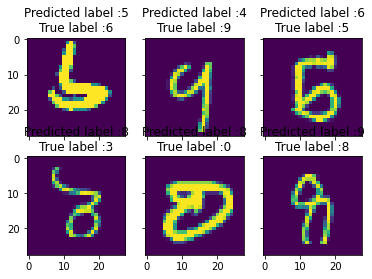

In [22]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

import matplotlib.pyplot as plt

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
            
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)